# K Nearest Neighbour Algorithm: Adult Earnings Dataset

----

This dataset comes from the UCI repository of machine learning databases. The task is to predict if an individual's annual income excceds $50,000 based on census data. More details are available in the original UCI documentation.

An individual’s annual income results from various factors. Intuitively, it's influenced by the individual’s education level, age, gender, occupation, etc.

I'll be using this dataset to perform a KNN classification.

Acknowledgements: 

This dataset named “adult” is found in the UCI machine learning repository
http://www.cs.toronto.edu/~delve/data/adult/desc.html

The detailed description on the dataset can be found in the original UCI documentation
http://www.cs.toronto.edu/~delve/data/adult/adultDetail.html

---

In [405]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize']=16,8
from sklearn.model_selection import train_test_split
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

My imports are complete for now, all other relevant packages will be imported as I go along.

In [406]:
df = pd.read_csv('adult-income-dataset.zip')

In [407]:
df.head(5)

,age,workclass,fnlwgt,education,educational-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,income
0,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50K
1,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K
2,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K
3,44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,>50K
4,18,?,103497,Some-college,10,Never-married,?,Own-child,White,Female,0,0,30,United-States,<=50K


---

# Data Wrangling and Feature Engineering

The dataset is now in a pandas dataframe. I'm going to rename the columns to make them easier to work with along the wrangling and mining steps. 

In [408]:
df.columns = ['age', 'working_class', 'fnlwgt', 'education', 'educationalnum',
       'marital_status', 'occupation', 'relationship', 'race', 'gender',
       'capital_gain', 'capital_loss', 'hours_per_week', 'native_country',
       'income']

The dataset is based on American Adults with a few other countries popping up. I've decided to remove these other countries from the dataset because they're only causing noise and have a lot of missing data. The dataset is 90% American.

In [412]:
us= df[df['native_country']== 'United-States']

In [413]:
us.shape

(43832, 15)

In [414]:
us.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 43832 entries, 0 to 48841
Data columns (total 15 columns):
age               43832 non-null int64
working_class     43832 non-null object
fnlwgt            43832 non-null int64
education         43832 non-null object
educationalnum    43832 non-null int64
marital_status    43832 non-null object
occupation        43832 non-null object
relationship      43832 non-null object
race              43832 non-null object
gender            43832 non-null object
capital_gain      43832 non-null int64
capital_loss      43832 non-null int64
hours_per_week    43832 non-null int64
native_country    43832 non-null object
income            43832 non-null object
dtypes: int64(6), object(9)
memory usage: 5.4+ MB


The dataset shows no missing values, and that's correct, but upon closer inspection, the missing data is not the normal NaN, but its a '?' which pandas is reading as a string. I'll replace the question marks with the norman NaN and then drop these records..

In [417]:
us = us.replace({'?': np.nan})
us = us.dropna()

Now that's been taken care of, let's check to see how the dataframe has changed

In [418]:
us.shape

(41292, 15)

---

# Feature Engineering

First I want to convert all my categorical variables into the categories in python as well, instead of them being just objects.

In [420]:
us.gender = us.gender.astype('category')
us.relationship = us.relationship.astype('category')
us.occupation = us.occupation.astype('category')
us.marital_status = us.marital_status.astype('category')
us.education = us.education.astype('category')
us.working_class = us.working_class.astype('category')


In [421]:
us.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 41292 entries, 0 to 48841
Data columns (total 15 columns):
age               41292 non-null int64
working_class     41292 non-null category
fnlwgt            41292 non-null int64
education         41292 non-null category
educationalnum    41292 non-null int64
marital_status    41292 non-null category
occupation        41292 non-null category
relationship      41292 non-null category
race              41292 non-null object
gender            41292 non-null category
capital_gain      41292 non-null int64
capital_loss      41292 non-null int64
hours_per_week    41292 non-null int64
native_country    41292 non-null object
income            41292 non-null object
dtypes: category(6), int64(6), object(3)
memory usage: 3.4+ MB


This dataset is very rich in categorical features, but sadly most of them can't be used to make any predictions as is. Thankfully I can convert or rather engineer these features and turn them into Dummy Variables, aware of the trap.

In [422]:
inc = pd.get_dummies(us.income,drop_first=True)
sex = pd.get_dummies(us.gender,drop_first=True)
rce = pd.get_dummies(us.race,drop_first=True)
rshp = pd.get_dummies(us.relationship,drop_first=True)
ooc = pd.get_dummies(us.occupation,drop_first=True)
ms = pd.get_dummies(us.marital_status,drop_first=True)
edu = pd.get_dummies(us.education,drop_first=True)
wcs = pd.get_dummies(us.working_class,drop_first=True)

In [423]:
us_alt = pd.concat([us,inc,rce,rshp,ooc,ms,edu,wcs],axis=1)
us_alt.head(2)

,age,working_class,fnlwgt,education,educationalnum,marital_status,occupation,relationship,race,gender,...,Masters,Preschool,Prof-school,Some-college,Local-gov,Private,Self-emp-inc,Self-emp-not-inc,State-gov,Without-pay
0,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,...,0,0,0,0,0,1,0,0,0,0
1,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,...,0,0,0,0,0,1,0,0,0,0


---

Now I have my features ready. I'll reduce the dimensionality by excluding the variables I don't need for my model.

In [424]:
usalt = us_alt.drop(['income','gender','race','relationship','marital_status','education',
                  'working_class','occupation','native_country'],axis=1)

In [425]:
usalt.head(3)

,age,fnlwgt,educationalnum,capital_gain,capital_loss,hours_per_week,>50K,Asian-Pac-Islander,Black,Other,...,Masters,Preschool,Prof-school,Some-college,Local-gov,Private,Self-emp-inc,Self-emp-not-inc,State-gov,Without-pay
0,25,226802,7,0,0,40,0,0,1,0,...,0,0,0,0,0,1,0,0,0,0
1,38,89814,9,0,0,50,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,28,336951,12,0,0,40,1,0,0,0,...,0,0,0,0,1,0,0,0,0,0


---

# Implementing the KNN Algorithm

My dataset is ready, now I need to get the necessary libraries to create my KNN model and let it do its magic.

In [426]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix

Creating my x & y variables for the split

In [427]:
X = usalt.drop('>50K',axis=1)
y = usalt['>50K']

In [428]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

Now I need to find the best K neighbours for this dataset, and I'll do that using the elbow method

In [429]:
err = []

for i in range(1,40):
    
    knn = KNeighborsClassifier(i).fit(X_train,y_train)
    pred = knn.predict(X_test)
    err.append(np.mean(pred != y_test))

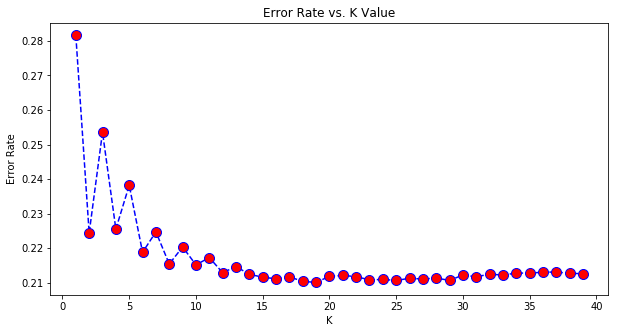

In [431]:
plt.figure(figsize=(10,5))
plt.plot(range(1,40),err,color='blue', linestyle='dashed', marker='o',
         markerfacecolor='red', markersize=10)
plt.title('Error Rate vs. K Value')
plt.xlabel('K')
plt.ylabel('Error Rate')
plt.show()

From the above elbow chart, it looks like 19 is the best k-neighbours value for the dataset because its at the lowest point, so now I'll fit it, and see how accurate I was with this model.

In [432]:
knn = KNeighborsClassifier(19).fit(X_test,y_test)
pred = knn.predict(X_test)

In [433]:
print(confusion_matrix(y_test,pred))
print('\n')
print(classification_report(y_test,pred))

[[9159   84]
 [2518  627]]


              precision    recall  f1-score   support

           0       0.78      0.99      0.88      9243
           1       0.88      0.20      0.33      3145

    accuracy                           0.79     12388
   macro avg       0.83      0.60      0.60     12388
weighted avg       0.81      0.79      0.74     12388



It appears my model was just shy of an A, and it came in at 79% accuracy. According to the source this is actually perfect!

# Thank once again for taking the time to review my work.  As always, Your feedback would really go a long way

---